In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('dark')
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import zscore
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.preprocessing import PowerTransformer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import GridSearchCV

import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
mic = pd.read_csv('Data file.csv')
mic.head()

Unnamed: 0  label       msisdn    aon  daily_decr30  daily_decr90  \
0           1      0  21408I70789  272.0   3055.050000   3065.150000   
1           2      1  76462I70374  712.0  12122.000000  12124.750000   
2           3      1  17943I70372  535.0   1398.000000   1398.000000   
3           4      1  55773I70781  241.0     21.228000     21.228000   
4           5      1  03813I82730  947.0    150.619333    150.619333   

   rental30  rental90  last_rech_date_ma  last_rech_date_da  ...  \
0    220.13    260.13                2.0                0.0  ...   
1   3691.26   3691.26               20.0                0.0  ...   
2    900.13    900.13                3.0                0.0  ...   
3    159.42    159.42               41.0                0.0  ...   
4   1098.90   1098.90                4.0                0.0  ...   

   maxamnt_loans30  medianamnt_loans30  cnt_loans90  amnt_loans90  \
0              6.0                 0.0          2.0            12   
1             12.0                 0.0          1.0            12   
2              6.0                 0.0          1.0             6   
3              6.0                 0.0          2.0            12   
4              6.0                 0.0          7.0            42   

   maxamnt_loans90  medianamnt_loans90  payback30  payback90  pcircle  \
0                6                 0.0  29.000000  29.000000      UPW   
1               12                 0.0   0.000000   0.000000      UPW   
2                6                 0.0   0.000000   0.000000      UPW   
3                6                 0.0   0.000000   0.000000      UPW   
4                6                 0.0   2.333333   2.333333      UPW   

        pdate  
0  2016-07-20  
1  2016-08-10  
2  2016-08-19  
3  2016-06-06  
4  2016-06-22  

[5 rows x 37 columns]

## Features
* msisdn: mobile number of user
* aon: age on cellular network in days
* daily_decr30: Daily amount spent from main account, averaged over last 30 days (in Indonesian Rupiah)
* daily_decr90: Daily amount spent from main account, averaged over last 90 days (in Indonesian Rupiah)
* rental30: Average main account balance over last 30 days
* rental90: Average main account balance over last 90 days
* last_rech_date_ma: Number of days till last recharge of main account
* last_rech_date_da: Number of days till last recharge of data account
* last_rech_amt_ma: Amount of last recharge of main account (in Indonesian Rupiah)
* cnt_ma_rech30: Number of times main account got recharged in last 30 days
* fr_ma_rech30: Frequency of main account recharged in last 30 days
* sumamnt_ma_rech30: Total amount of recharge in main account over last 30 days (in Indonesian Rupiah)
* medianamnt_ma_rech30: Median of amount of recharges done in main account over last 30 days at user level (in Indonesian Rupiah)
* medianmarechprebal30: Median of main account balance just before recharge in last 30 days at user level (in Indonesian Rupiah)
* cnt_ma_rech90: Number of times main account got recharged in last 90 days
* fr_ma_rech90: Frequency of main account recharged in last 90 days
* sumamnt_ma_rech90: Total amount of recharge in main account over last 90 days (in Indonasian Rupiah)
* medianamnt_ma_rech90: Median of amount of recharges done in main account over last 90 days at user level (in Indonasian Rupiah)
* medianmarechprebal90: Median of main account balance just before recharge in last 90 days at user level (in Indonasian Rupiah)
* cnt_da_rech30: Number of times data account got recharged in last 30 days
* fr_da_rech30: Frequency of data account recharged in last 30 days
* cnt_da_rech90: Number of times data account got recharged in last 90 days
* fr_da_rech90: Frequency of data account recharged in last 90 days
* cnt_loans30: Number of loans taken by user in last 30 days
* amnt_loans30: Total amount of loans taken by user in last 30 days
* maxamnt_loans30: maximum amount of loan taken by the user in last 30 days
* medianamnt_loans30: Median of amounts of loan taken by the user in last 30 days
* cnt_loans90: Number of loans taken by user in last 90 days
* amnt_loans90: Total amount of loans taken by user in last 90 days
* maxamnt_loans90: maximum amount of loan taken by the user in last 90 days
* medianamnt_loans90: Median of amounts of loan taken by the user in last 90 days
* payback30: Average payback time in days over last 30 days
* payback90: Average payback time in days over last 90 days
* pcircle: telecom circle
* pdate: date

## Target
* label: Flag indicating whether the user paid back the credit amount within 5 days of issuing the loan{1:success, 0:failure}

# EDA

In [4]:
mic.shape

(209593, 37)

Shape of our dataset is 209593, 37

In [5]:
mic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209593 entries, 0 to 209592
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            209593 non-null  int64  
 1   label                 209593 non-null  int64  
 2   msisdn                209593 non-null  object 
 3   aon                   209593 non-null  float64
 4   daily_decr30          209593 non-null  float64
 5   daily_decr90          209593 non-null  float64
 6   rental30              209593 non-null  float64
 7   rental90              209593 non-null  float64
 8   last_rech_date_ma     209593 non-null  float64
 9   last_rech_date_da     209593 non-null  float64
 10  last_rech_amt_ma      209593 non-null  int64  
 11  cnt_ma_rech30         209593 non-null  int64  
 12  fr_ma_rech30          209593 non-null  float64
 13  sumamnt_ma_rech30     209593 non-null  float64
 14  medianamnt_ma_rech30  209593 non-null  float64
 15  

#### Information of the Dataset.

* RangeIndex: 0 to 209592
* Data columns: 37
* dtypes: float64(21), int64(13), object(3)

In [6]:
mic.describe().T

count           mean           std           min  \
Unnamed: 0            209593.0  104797.000000  60504.431823      1.000000   
label                 209593.0       0.875177      0.330519      0.000000   
aon                   209593.0    8112.343445  75696.082531    -48.000000   
daily_decr30          209593.0    5381.402289   9220.623400    -93.012667   
daily_decr90          209593.0    6082.515068  10918.812767    -93.012667   
rental30              209593.0    2692.581910   4308.586781 -23737.140000   
rental90              209593.0    3483.406534   5770.461279 -24720.580000   
last_rech_date_ma     209593.0    3755.847800  53905.892230    -29.000000   
last_rech_date_da     209593.0    3712.202921  53374.833430    -29.000000   
last_rech_amt_ma      209593.0    2064.452797   2370.786034      0.000000   
cnt_ma_rech30         209593.0       3.978057      4.256090      0.000000   
fr_ma_rech30          209593.0    3737.355121  53643.625172      0.000000   
sumamnt_ma_rech30     209593.0    7704.501157  10139.621714      0.000000   
medianamnt_ma_rech30  209593.0    1812.817952   2070.864620      0.000000   
medianmarechprebal30  209593.0    3851.927942  54006.374433   -200.000000   
cnt_ma_rech90         209593.0       6.315430      7.193470      0.000000   
fr_ma_rech90          209593.0       7.716780     12.590251      0.000000   
sumamnt_ma_rech90     209593.0   12396.218352  16857.793882      0.000000   
medianamnt_ma_rech90  209593.0    1864.595821   2081.680664      0.000000   
medianmarechprebal90  209593.0      92.025541    369.215658   -200.000000   
cnt_da_rech30         209593.0     262.578110   4183.897978      0.000000   
fr_da_rech30          209593.0    3749.494447  53885.414979      0.000000   
cnt_da_rech90         209593.0       0.041495      0.397556      0.000000   
fr_da_rech90          209593.0       0.045712      0.951386      0.000000   
cnt_loans30           209593.0       2.758981      2.554502      0.000000   
amnt_loans30          209593.0      17.952021     17.379741      0.000000   
maxamnt_loans30       209593.0     274.658747   4245.264648      0.000000   
medianamnt_loans30    209593.0       0.054029      0.218039      0.000000   
cnt_loans90           209593.0      18.520919    224.797423      0.000000   
amnt_loans90          209593.0      23.645398     26.469861      0.000000   
maxamnt_loans90       209593.0       6.703134      2.103864      0.000000   
medianamnt_loans90    209593.0       0.046077      0.200692      0.000000   
payback30             209593.0       3.398826      8.813729      0.000000   
payback90             209593.0       4.321485     10.308108      0.000000   

                            25%            50%        75%            max  
Unnamed: 0            52399.000  104797.000000  157195.00  209593.000000  
label                     1.000       1.000000       1.00       1.000000  
aon                     246.000     527.000000     982.00  999860.755168  
daily_decr30             42.440    1469.175667    7244.00  265926.000000  
daily_decr90             42.692    1500.000000    7802.79  320630.000000  
rental30                280.420    1083.570000    3356.94  198926.110000  
rental90                300.260    1334.000000    4201.79  200148.110000  
last_rech_date_ma         1.000       3.000000       7.00  998650.377733  
last_rech_date_da         0.000       0.000000       0.00  999171.809410  
last_rech_amt_ma        770.000    1539.000000    2309.00   55000.000000  
cnt_ma_rech30             1.000       3.000000       5.00     203.000000  
fr_ma_rech30              0.000       2.000000       6.00  999606.368132  
sumamnt_ma_rech30      1540.000    4628.000000   10010.00  810096.000000  
medianamnt_ma_rech30    770.000    1539.000000    1924.00   55000.000000  
medianmarechprebal30     11.000      33.900000      83.00  999479.419319  
cnt_ma_rech90             2.000       4.000000       8.00     336.000000  
fr_ma_rech90              0.000       2.000000       8

#### Short description of our dataset, this will give us the short summary of dataset

* Counts
* Mean
* Standard deviation
* Minimum
* 1st quantile
* 2nd quantile
* 3rd quantile
* Maximum value of each columns.

### - Dropping unwanted columns.

In [7]:
mic.drop(columns = ['Unnamed: 0','msisdn','pcircle','pdate'],axis = 1,inplace = True)

#### Dropped columns

* Unnamed: 0 --> Unnecessary Column.
* msisdn --> Object column & mobile number of user, which will not be needed.
* pcircle --> Object column & telecom circle and every one have same pcircle data i.e. UPW
* pdate --> Object column & date column, which will not be needed.

# Visualization

In [8]:
def plot(x,y,data):
    plt.scatter(x,y,data=mic)
    plt.xlabel(x)
    plt.ylabel(y)
    print('Scatterpot between',x,'and',y)
    plt.show()

Scatterpot between label and aon


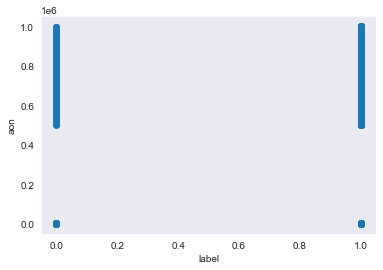

In [9]:
plot(x = 'label', y = 'aon', data = mic)

Both are equally distributed.

Scatterpot between label and daily_decr30


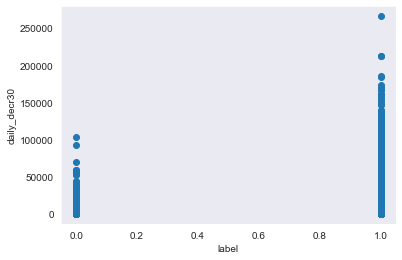

Scatterpot between label and daily_decr90


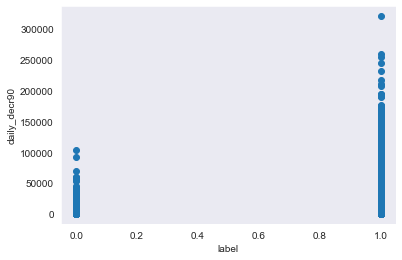

Scatterpot between daily_decr30 and daily_decr90


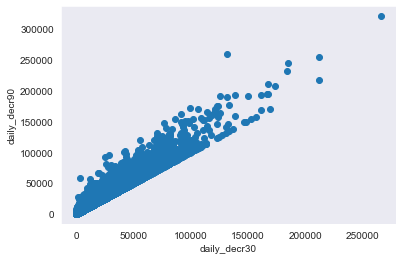

In [10]:
plot(x = 'label', y = 'daily_decr30', data = mic)
plot(x = 'label', y = 'daily_decr90', data = mic)
plot(x = 'daily_decr30', y = 'daily_decr90', data = mic)

Scatterpot between label and rental30


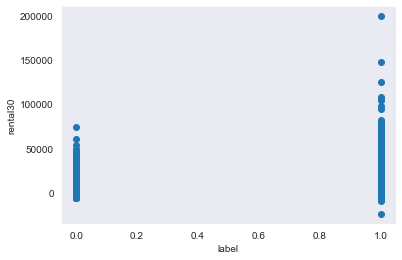

Scatterpot between label and rental90


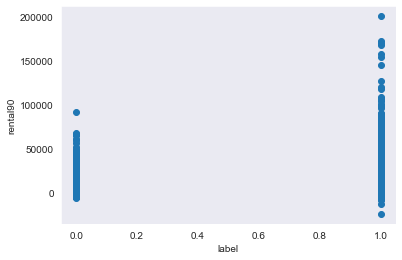

Scatterpot between rental30 and rental90


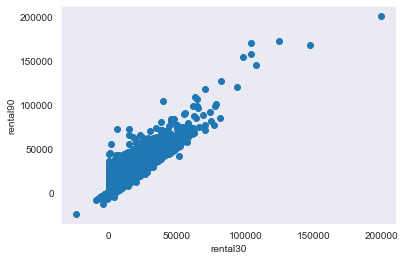

In [11]:
plot(x = 'label', y = 'rental30', data = mic)
plot(x = 'label', y = 'rental90', data = mic)
plot(x = 'rental30', y = 'rental90', data = mic)

Scatterpot between label and last_rech_date_ma


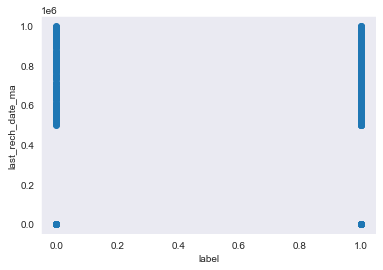

Scatterpot between label and last_rech_date_da


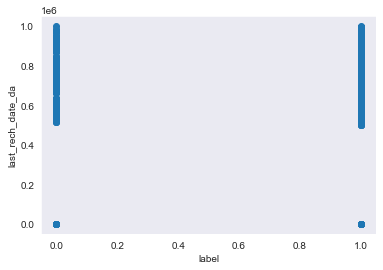

Scatterpot between label and last_rech_amt_ma


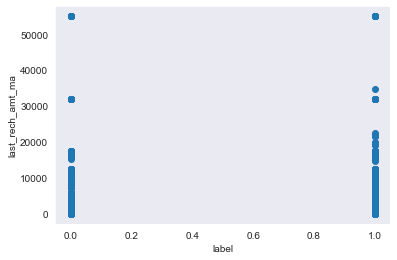

In [12]:
plot(x = 'label', y = 'last_rech_date_ma', data = mic)
plot(x = 'label', y = 'last_rech_date_da', data = mic)
plot(x = 'label', y = 'last_rech_amt_ma', data = mic)

Scatterpot between label and cnt_ma_rech30


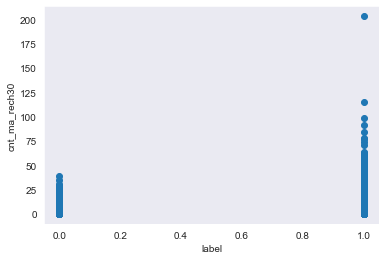

Scatterpot between label and cnt_ma_rech90


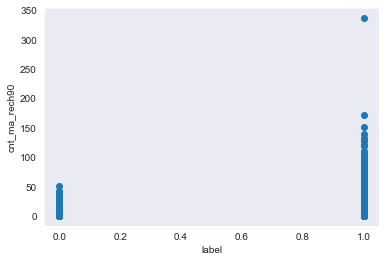

Scatterpot between cnt_ma_rech30 and cnt_ma_rech90


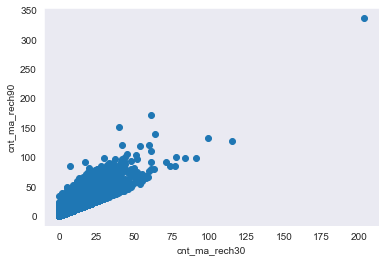

In [13]:
plot(x = 'label', y = 'cnt_ma_rech30', data = mic)
plot(x = 'label', y = 'cnt_ma_rech90', data = mic)
plot(x = 'cnt_ma_rech30', y = 'cnt_ma_rech90', data = mic)

Scatterpot between label and fr_ma_rech30


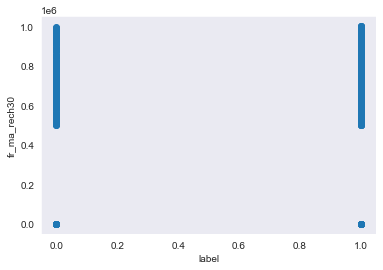

Scatterpot between label and fr_ma_rech90


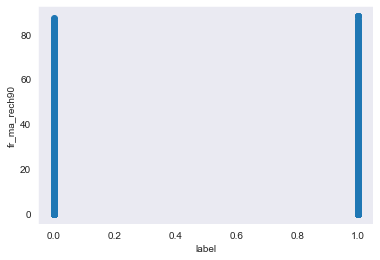

Scatterpot between fr_ma_rech30 and fr_ma_rech90


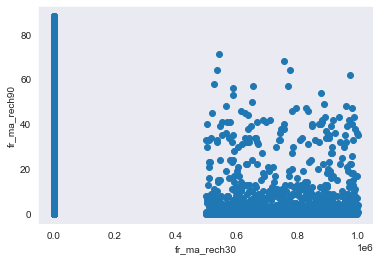

In [14]:
plot(x = 'label', y = 'fr_ma_rech30', data = mic)
plot(x = 'label', y = 'fr_ma_rech90', data = mic)
plot(x = 'fr_ma_rech30', y = 'fr_ma_rech90', data = mic)

Scatterpot between label and sumamnt_ma_rech30


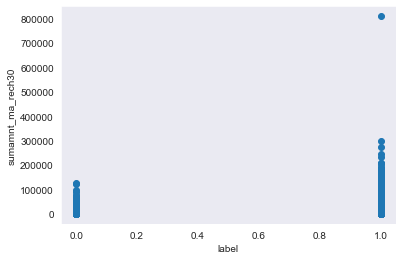

Scatterpot between label and sumamnt_ma_rech90


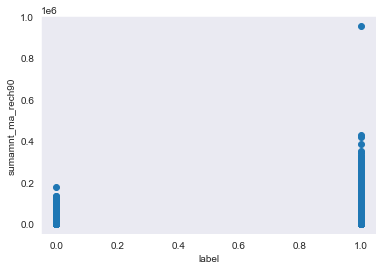

Scatterpot between sumamnt_ma_rech30 and sumamnt_ma_rech90


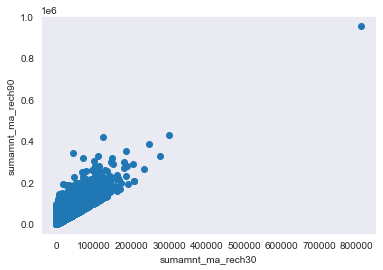

In [15]:
plot(x = 'label', y = 'sumamnt_ma_rech30', data = mic)
plot(x = 'label', y = 'sumamnt_ma_rech90', data = mic)
plot(x = 'sumamnt_ma_rech30', y = 'sumamnt_ma_rech90', data = mic)

Scatterpot between label and medianamnt_ma_rech30


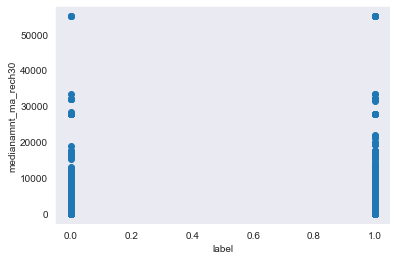

Scatterpot between label and medianamnt_ma_rech90


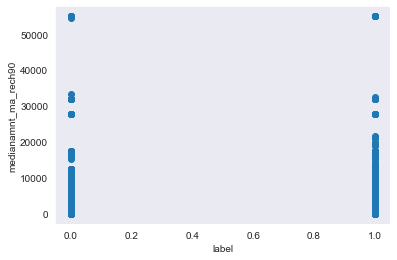

Scatterpot between medianamnt_ma_rech30 and medianamnt_ma_rech90


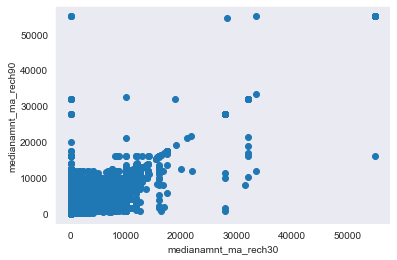

In [16]:
plot(x = 'label', y = 'medianamnt_ma_rech30', data = mic)
plot(x = 'label', y = 'medianamnt_ma_rech90', data = mic)
plot(x = 'medianamnt_ma_rech30', y = 'medianamnt_ma_rech90', data = mic)

Scatterpot between label and medianmarechprebal30


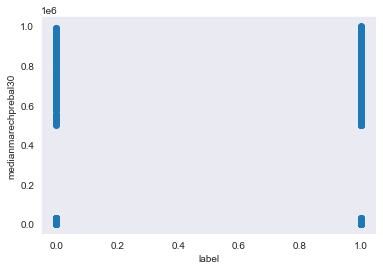

Scatterpot between label and medianmarechprebal90


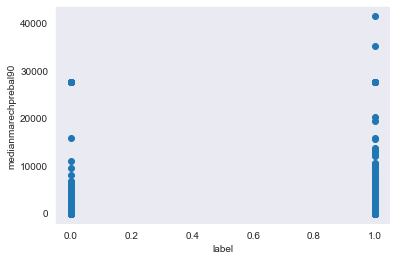

Scatterpot between medianmarechprebal30 and medianmarechprebal90


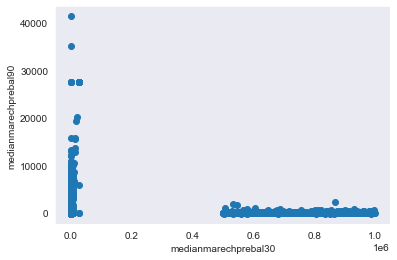

In [17]:
plot(x = 'label', y = 'medianmarechprebal30', data = mic)
plot(x = 'label', y = 'medianmarechprebal90', data = mic)
plot(x = 'medianmarechprebal30', y = 'medianmarechprebal90', data = mic)

Scatterpot between label and cnt_da_rech30


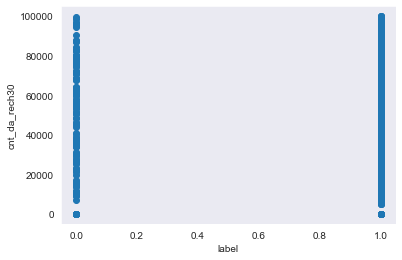

Scatterpot between label and cnt_da_rech90


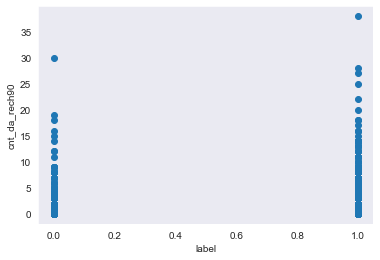

Scatterpot between cnt_da_rech30 and cnt_da_rech90


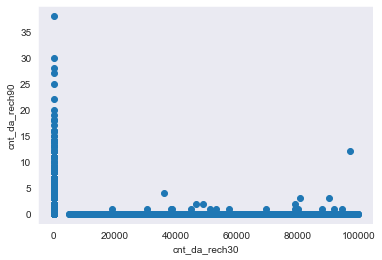

In [18]:
plot(x = 'label', y = 'cnt_da_rech30', data = mic)
plot(x = 'label', y = 'cnt_da_rech90', data = mic)
plot(x = 'cnt_da_rech30', y = 'cnt_da_rech90', data = mic)

Scatterpot between label and fr_da_rech30


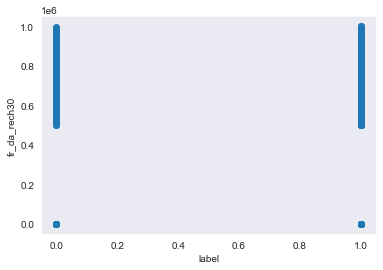

Scatterpot between label and fr_da_rech90


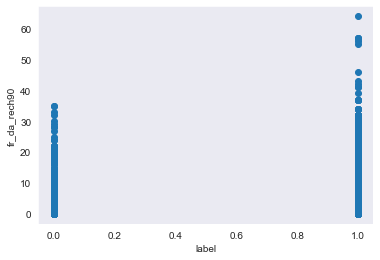

Scatterpot between fr_da_rech30 and fr_da_rech90


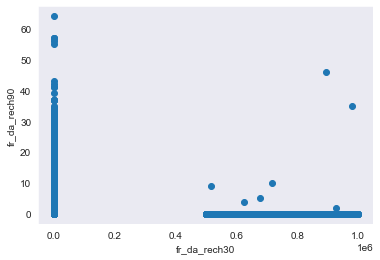

In [19]:
plot(x = 'label', y = 'fr_da_rech30', data = mic)
plot(x = 'label', y = 'fr_da_rech90', data = mic)
plot(x = 'fr_da_rech30', y = 'fr_da_rech90', data = mic)

Scatterpot between label and cnt_loans30


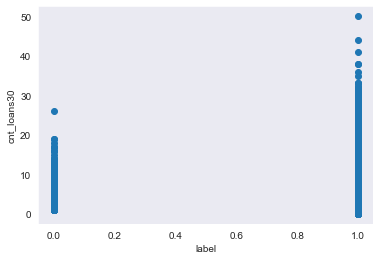

Scatterpot between label and cnt_loans90


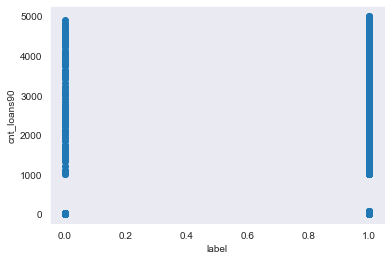

Scatterpot between cnt_loans30 and cnt_loans90


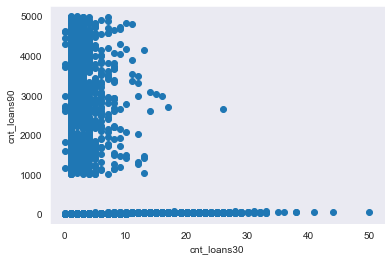

In [20]:
plot(x = 'label', y = 'cnt_loans30', data = mic)
plot(x = 'label', y = 'cnt_loans90', data = mic)
plot(x = 'cnt_loans30', y = 'cnt_loans90', data = mic)

Scatterpot between label and amnt_loans30


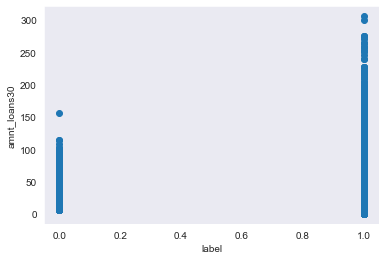

Scatterpot between label and amnt_loans90


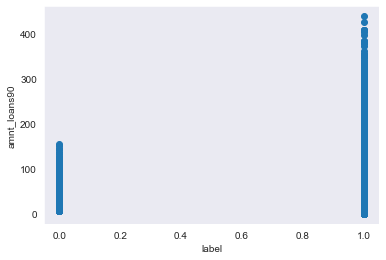

Scatterpot between amnt_loans30 and amnt_loans90


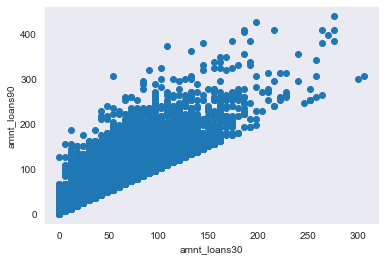

In [21]:
plot(x = 'label', y = 'amnt_loans30', data = mic)
plot(x = 'label', y = 'amnt_loans90', data = mic)
plot(x = 'amnt_loans30', y = 'amnt_loans90', data = mic)

Scatterpot between label and maxamnt_loans30


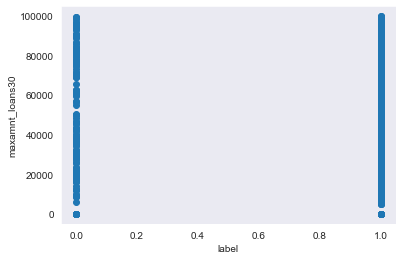

Scatterpot between label and maxamnt_loans90


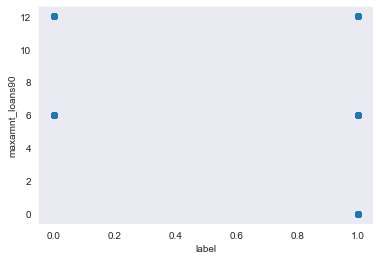

Scatterpot between maxamnt_loans30 and maxamnt_loans90


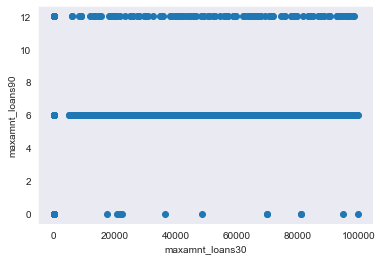

In [22]:
plot(x = 'label', y = 'maxamnt_loans30', data = mic)
plot(x = 'label', y = 'maxamnt_loans90', data = mic)
plot(x = 'maxamnt_loans30', y = 'maxamnt_loans90', data = mic)

Scatterpot between label and medianamnt_loans30


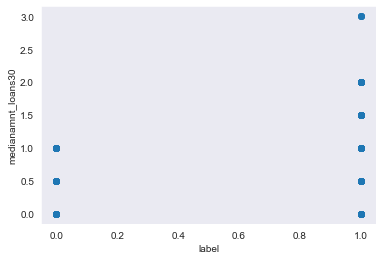

Scatterpot between label and medianamnt_loans90


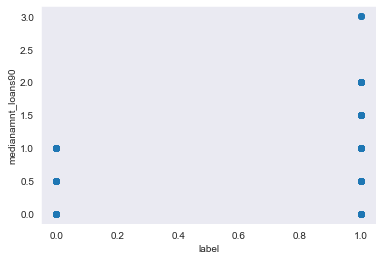

Scatterpot between medianamnt_loans30 and medianamnt_loans90


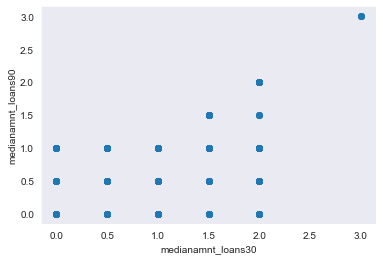

In [23]:
plot(x = 'label', y = 'medianamnt_loans30', data = mic)
plot(x = 'label', y = 'medianamnt_loans90', data = mic)
plot(x = 'medianamnt_loans30', y = 'medianamnt_loans90', data = mic)

Scatterpot between label and payback30


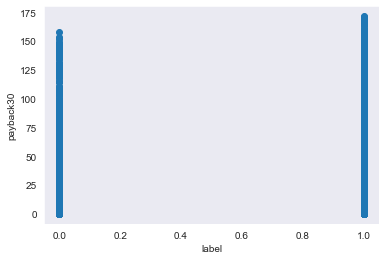

Scatterpot between label and payback90


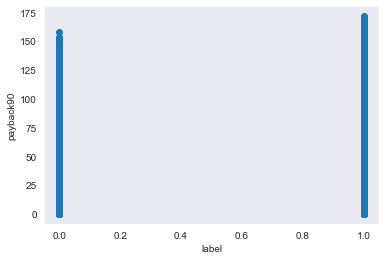

Scatterpot between payback30 and payback90


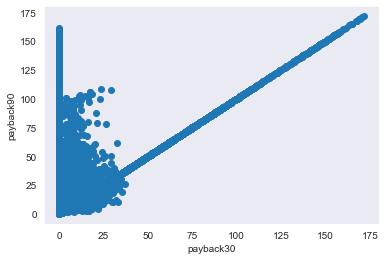

In [24]:
plot(x = 'label', y = 'payback30', data = mic)
plot(x = 'label', y = 'payback90', data = mic)
plot(x = 'payback30', y = 'payback90', data = mic)

# Correlation

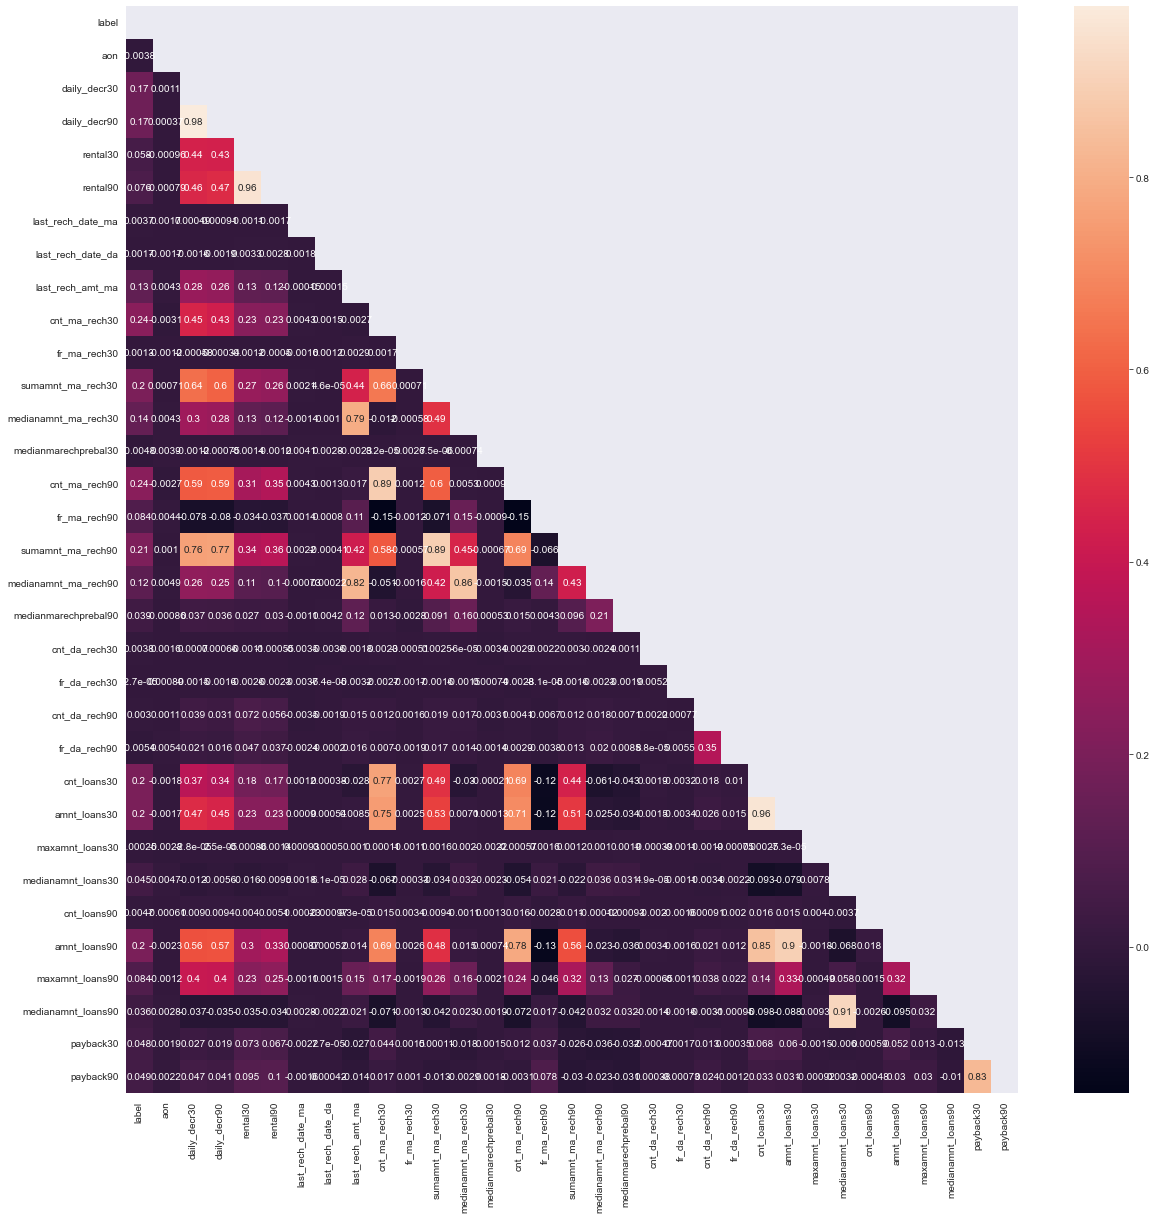

In [25]:
df = mic.corr()
mask = np.triu(np.ones_like(df))
plt.figure(figsize = (20,20))
sns.heatmap(df,annot = True,mask = mask)
plt.show()

#### Found That:

* daily_decr90 & daily_decr30 is 98% correlated.
* rental30 & rental90 is 96% correlated.
* cnt_ma_rech90 & cnt_ma_rech30 is 89% correlated.
* sumamnt_ma_rech30 & sumamnt_ma_rech90 is 89% correlated.
* medianamnt_ma_rech90 & medianamnt_ma_rech30 is 86% correlated.
* cnt_loans30 & amnt_loans30 is 96% correlated.
* amnt_loans90 & amnt_loans30 is 90% correlated.
* medianamnt_loans90 & medianamnt_loans30 is 91% correlated.
* payback30 & payback90 is 83% correlated.

#### - Dropping all the correlation problem columns(which are correlated more than 80%).

In [26]:
mic.drop(columns = ['daily_decr90','rental30','cnt_ma_rech90','sumamnt_ma_rech30','medianamnt_ma_rech90','cnt_loans30','amnt_loans90','medianamnt_loans90','payback30'],axis = 1,inplace = True)


# Feature Selection
### - Sepeating Features & Target.

In [27]:
x = mic.drop('label',axis = 1)
y = mic.label

### - Applying SelectKBest.

In [28]:
best_feature = SelectKBest(score_func = f_classif, k =23)
fit = best_feature.fit(x,y)

In [29]:
brt_score = pd.DataFrame(fit.scores_)
brt_column = pd.DataFrame(x.columns)

In [30]:
feature_score = pd.concat([brt_column,brt_score], axis = 1)
feature_score.columns = ['Feature Name','Scores']
feature_score.nlargest(32,'Scores')

Feature Name        Scores
6          cnt_ma_rech30  12510.083303
11     sumamnt_ma_rech90   9268.913603
17          amnt_loans30   8486.771736
1           daily_decr30   6109.541601
8   medianamnt_ma_rech30   4281.623215
5       last_rech_amt_ma   3705.420270
10          fr_ma_rech90   1503.150310
21       maxamnt_loans90   1494.523796
2               rental90   1202.229543
22             payback90    508.224020
19    medianamnt_loans30    417.538139
12  medianmarechprebal90    324.209116
16          fr_da_rech90      6.152367
9   medianmarechprebal30      4.887441
20           cnt_loans90      4.695565
13         cnt_da_rech30      3.070127
0                    aon      3.002765
3      last_rech_date_ma      2.913269
15         cnt_da_rech90      1.884674
4      last_rech_date_da      0.613610
7           fr_ma_rech30      0.370856
18       maxamnt_loans30      0.012865
14          fr_da_rech30      0.000147

### Dropping all the columns whose score is less than 1.

In [31]:
mic.drop(columns = ['last_rech_date_da','fr_ma_rech30','maxamnt_loans30','fr_da_rech30'],axis = 1,inplace = True)

# Normal Distribution

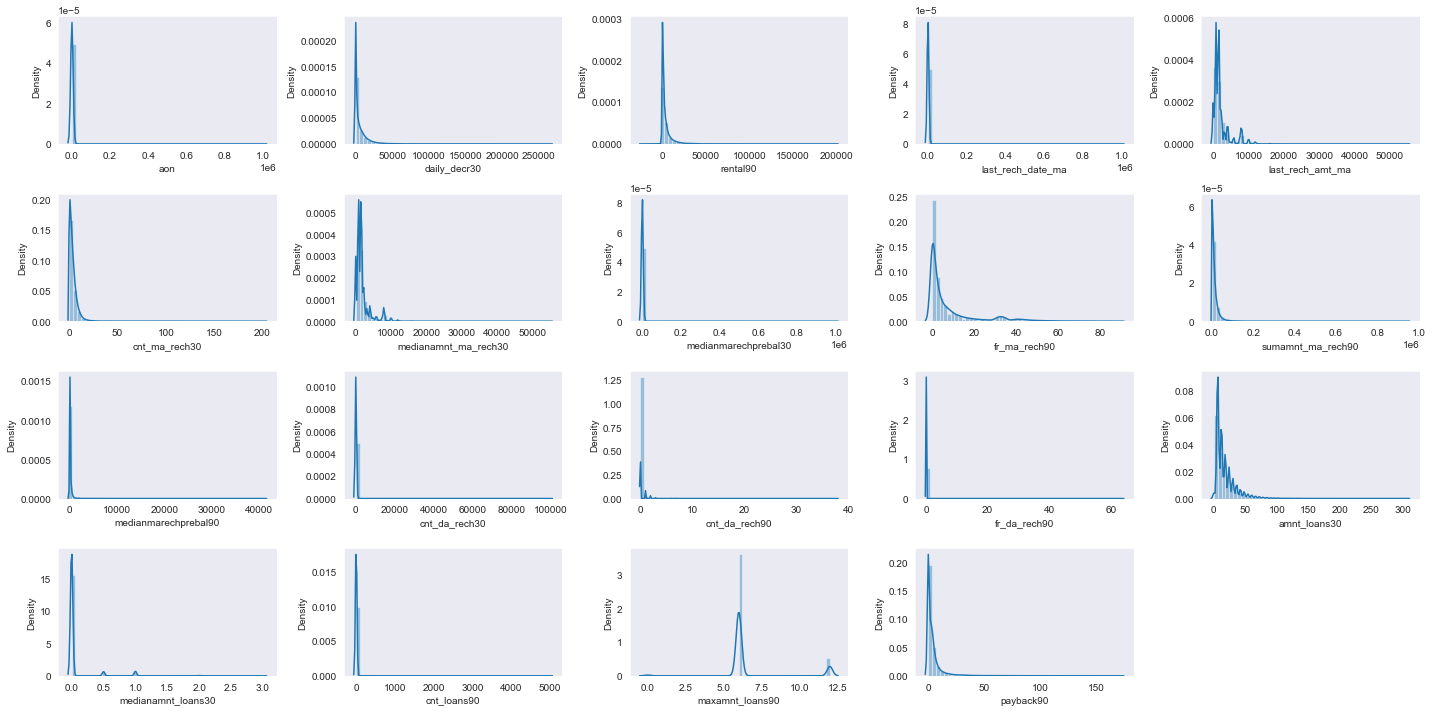

In [32]:
plt.figure(figsize=(20,10))
plotnumber = 1

for column in mic.drop('label',axis = 1):
    if plotnumber <= 20:
        ax = plt.subplot(4,5,plotnumber)
        sns.distplot(mic[column])
        plt.xlabel(column)
    
    plotnumber+=1
plt.tight_layout()

Skewness is present in our dataset.

# Outliers

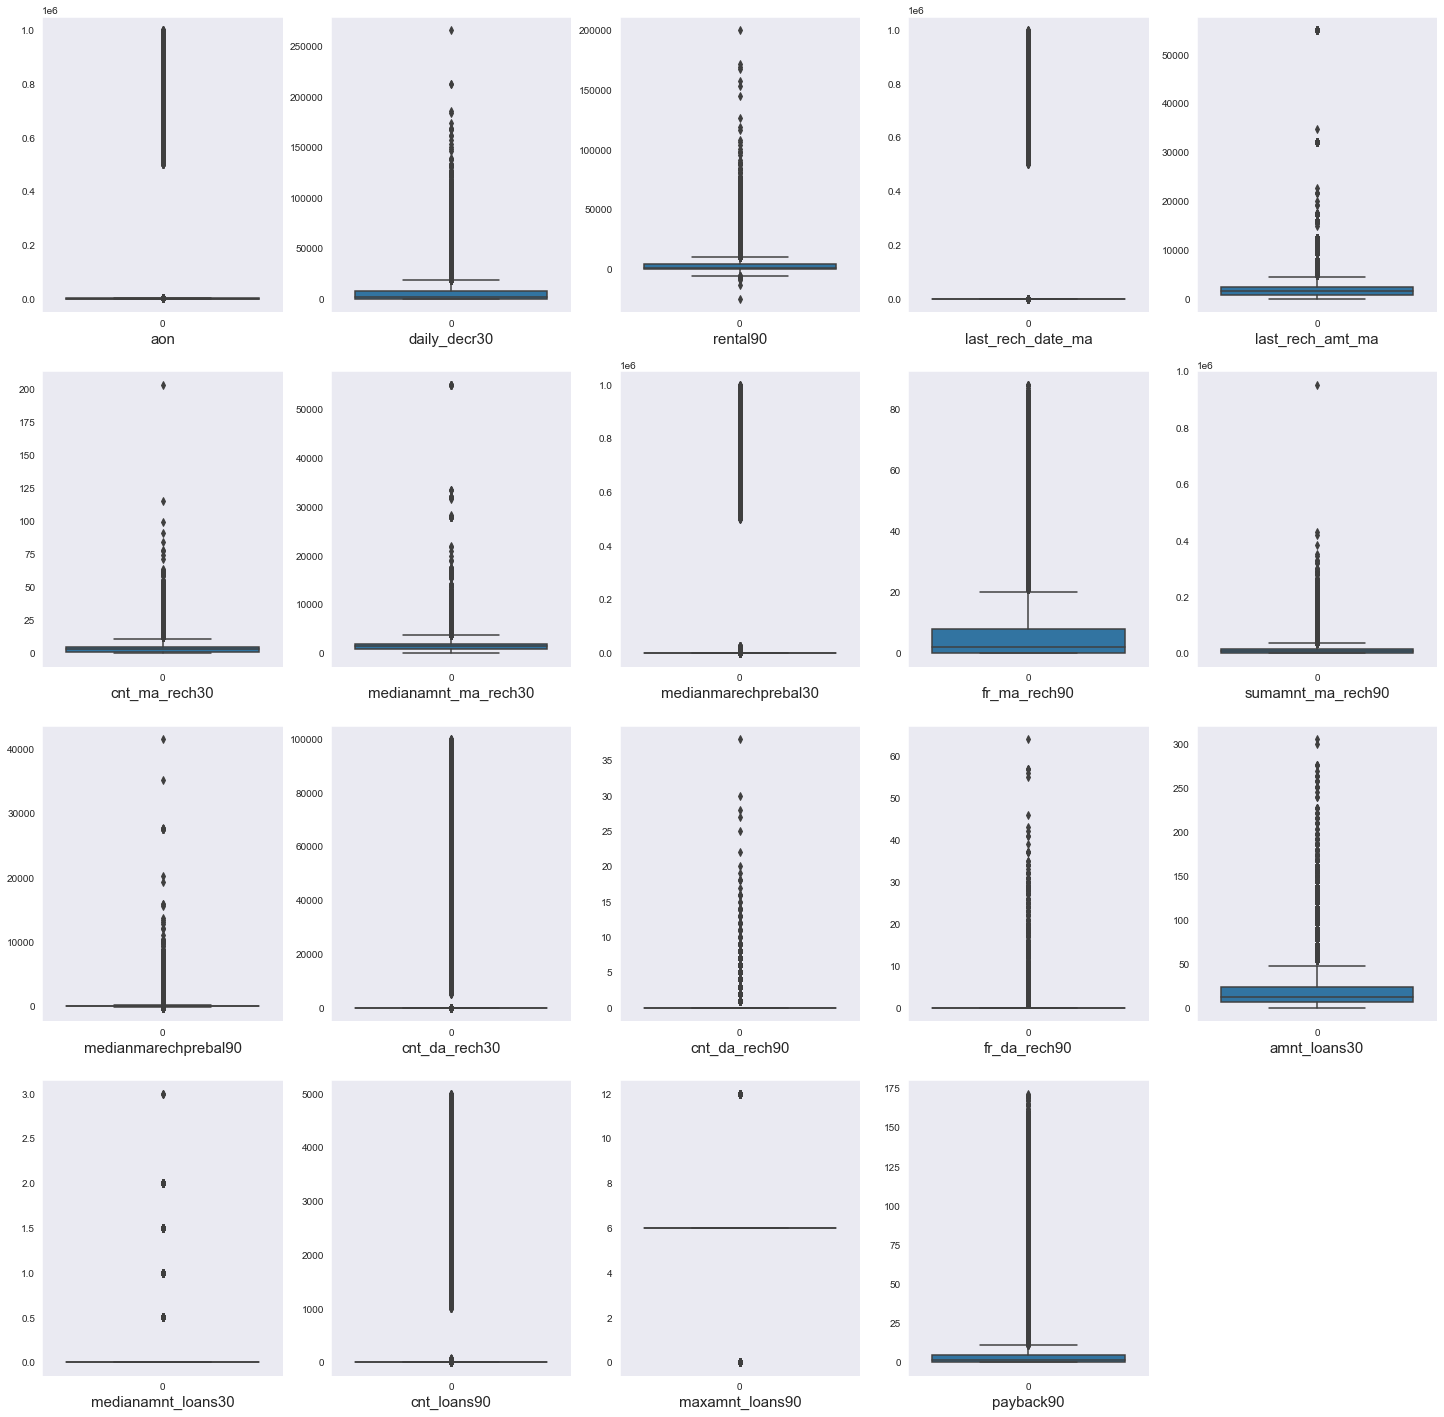

In [33]:
plt.figure(figsize = (25,25))
graph = 1
for column in mic.drop('label',axis = 1):
    if graph <= 20:
        plt.subplot(4,5,graph)
        ax = sns.boxplot(data = mic[column])
        plt.xlabel(column, fontsize = 15)
    graph += 1
plt.show()

So many outliers are there.

#### - Code to remove outliers.

In [34]:
'''
x = mic.drop('label',axis = 1)
y = mic.label
z = np.abs(zscore(mic))
z.shape
threshold = 3
print(np.where(z>3))
len(np.where(z>3)[0])
mic_new = mic[(z<3).all(axis = 1)]
print('Old',mic.shape)
print('New',mic_new.shape)
loss = (209593 - 161465)/209593*100
print(loss,'%')
22.96%
'''

"\nx = mic.drop('label',axis = 1)\ny = mic.label\nz = np.abs(zscore(mic))\nz.shape\nthreshold = 3\nprint(np.where(z>3))\nlen(np.where(z>3)[0])\nmic_new = mic[(z<3).all(axis = 1)]\nprint('Old',mic.shape)\nprint('New',mic_new.shape)\nloss = (209593 - 161465)/209593*100\nprint(loss,'%')\n22.96%\n"

Not removing outliers because:

* Removing outliers may cause to data loss.
* Approx 22% of data is lost after outlier removal.
* Only 7% - 8% is allowed.

#### - Transformation

In [35]:
feature = [ 'aon', 'daily_decr30', 'rental90', 'last_rech_date_ma',
       'last_rech_amt_ma', 'cnt_ma_rech30', 'medianamnt_ma_rech30',
       'medianmarechprebal30', 'fr_ma_rech90', 'sumamnt_ma_rech90',
       'medianmarechprebal90', 'cnt_da_rech30', 'cnt_da_rech90',
       'fr_da_rech90', 'amnt_loans30', 'medianamnt_loans30', 'cnt_loans90',
       'maxamnt_loans90', 'payback90']

In [36]:
power = PowerTransformer(method = 'yeo-johnson')
mic[feature] = power.fit_transform(mic[feature].values)

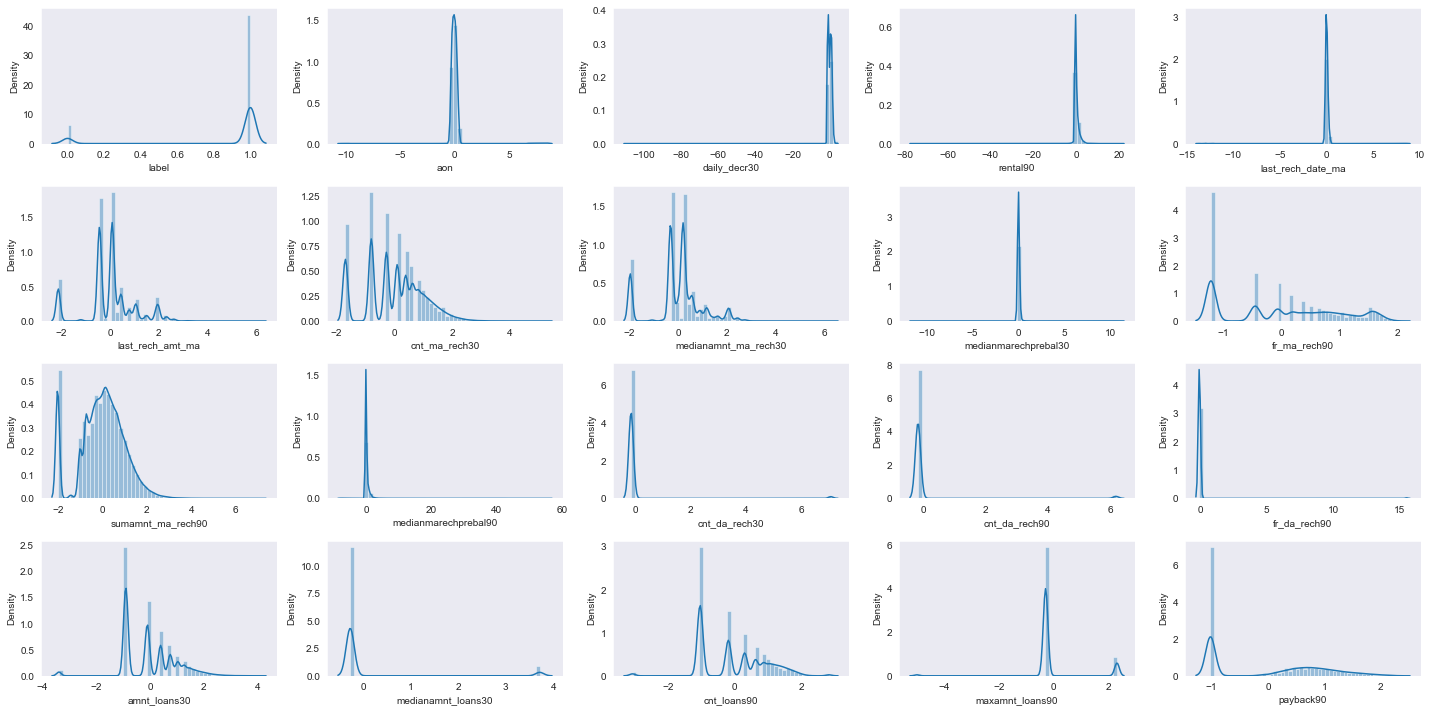

In [37]:
plt.figure(figsize=(20,10))
plotnumber = 1

for column in mic:
    if plotnumber <= 20:
        ax = plt.subplot(4,5,plotnumber)
        sns.distplot(mic[column])
        plt.xlabel(column)
    
    plotnumber+=1
plt.tight_layout()

After applying powertransformation, our dataset seems to be fine for further.

# Imbalanced Target Columns

<AxesSubplot:xlabel='label', ylabel='count'>

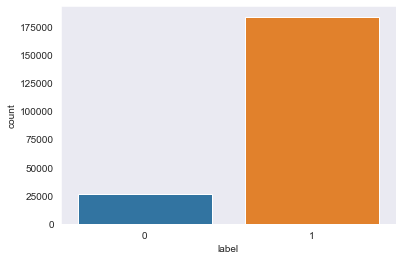

In [38]:
sns.countplot(mic['label'])

The target column is imbalanced.

* Label ‘1’ has approximately 87.5% records.
* Label ‘0’ has approximately 12.5% records.

#### - Oversampling

In [39]:
no = mic[mic.label == 0]
yes = mic[mic.label == 1]
no_oversampled = resample(no, replace=True, n_samples=len(yes), random_state=123)
os = pd.concat([yes, no_oversampled])

<AxesSubplot:xlabel='label', ylabel='count'>

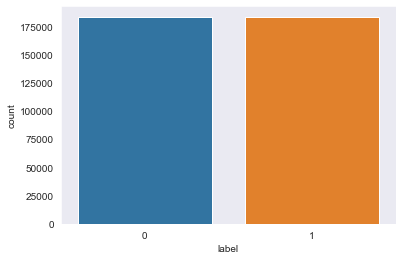

In [40]:
sns.countplot(os['label'])

Now, our target column is balanced.

# FINAL DATASET.

In [41]:
os

label       aon  daily_decr30  rental90  last_rech_date_ma  \
1           1  0.036453      1.116021  0.148082           0.191368   
2           1 -0.034659     -0.007508 -0.409047           0.000044   
3           1 -0.199213     -1.031486 -0.597731           0.299360   
4           1  0.114880     -0.682337 -0.364212           0.021231   
5           1 -0.020350      0.192866 -0.535813          -0.025513   
...       ...       ...           ...       ...                ...   
137318      0 -0.136189     -0.212944  0.385058          -0.107221   
18870       0 -0.105444     -0.218361 -0.239418           0.070105   
201416      0 -0.139194     -0.119902  0.558764           0.400637   
88348       0 -0.196996     -1.093647 -0.630037           0.154056   
16169       0 -0.333103      0.697120  1.007762          -0.107221   

        last_rech_amt_ma  cnt_ma_rech30  medianamnt_ma_rech30  \
1               1.501277      -0.799355              1.632404   
2               0.083417      -0.799355              0.208594   
3              -0.291052      -1.694157             -1.961729   
4               0.449550       0.992270              0.575164   
5               0.083417       0.384542              0.208594   
...                  ...            ...                   ...   
137318         -2.115772      -1.694157             -1.961729   
18870          -0.432065      -0.799355             -0.305859   
201416          0.087772      -1.694157             -1.961729   
88348           0.083417      -0.799355              0.208594   
16169          -2.115772      -1.694157             -1.961729   

        medianmarechprebal30  fr_ma_rech90  sumamnt_ma_rech90  \
1                   0.016926     -1.207069          -0.086685   
2                   0.020765     -1.207069          -0.760548   
3                  -0.063971     -1.207069          -0.949332   
4                  -0.011178     -0.060965           0.974121   
5                  -0.027945     -1.207069           0.395193   
...                      ...           ...                ...   
137318             -0.063971     -1.207069          -2.025016   
18870              -0.028529      1.641781          -0.579379   
201416             -0.063971     -1.207069          -0.758385   
88348               0.039379     -1.207069          -0.760548   
16169              -0.063971     -1.207069          -2.025016   

        medianmarechprebal90  cnt_da_rech30  cnt_da_rech90  fr_da_rech90  \
1                  -0.002722      -0.141497       -0.16211     -0.064375   
2                   0.023770      -0.141497       -0.16211     -0.064375   
3                  -0.370968      -0.141497       -0.16211     -0.064375   
4                  -0.142977      -0.141497       -0.16211     -0.064375   
5                  -0.029043      -0.141497       -0.16211     -0.064375   
...                      ...            ...            ...           ...   
137318             -0.399841      -0.141497       -0.16211     -0.064375   
18870               0.627290      -0.141497       -0.16211     -0.064375   
201416             -0.329979      -0.141497       -0.16211     -0.064375   
88348               0.159941      -0.141497       -0.16211     -0.064375   
16169              -0.399841      -0.141497       -0.16211     -0.064375   

        amnt_loans30  medianamnt_loans30  cnt_loans90  maxamnt_loans90  \
1          -0.097563           -0.269051    -1.034294         2.325828   
2          -0.894782           -0.269051    -1.034294        -0.285611   
3          -0.097563           -0.269051    -0.186805        -0.285611   
4           1.454951           -0.269051     1.180312        -0.285611   
5           0.393236           -0.269051     0.300689        -0.285611   
...              ...                 ...          ...              ...   
137318     -0.894782           -0.269051    -1.034294        -0.285611   
18870      -0.894782           -0.269051    -0.186805        -0.285611   
201416     -0.894782      

# Model Building
#### - Seperating the features and target.

In [42]:
x = os.drop('label',axis =1)
y = os.label

#### - Train Test Split.

In [43]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.25, random_state = 9)

#### - Function for training & testing.

In [44]:
def score(clas, x_train, x_test, y_train, y_test, train = True):
    if train:
        y_pred = clas.predict(x_train)
        print('\n ----- Train Result ----- \n')
        print('Accuracy Score:', accuracy_score(y_train,y_pred))
        print('\n ----- Classification Report ----- \n', classification_report(y_train,y_pred))
        print('\n ----- Confusion matrix ----- \n', confusion_matrix(y_train,y_pred))
    
    elif train == False:
        pred = clas.predict(x_test)
        print('\n ----- Test Result ----- \n')
        print('Accuracy Score:', accuracy_score(y_test,pred))
        print('\n ----- Classification Report ----- \n', classification_report(y_test,pred))
        print('\n ----- Confusion matrix ----- \n', confusion_matrix(y_test,pred))
        print('\n ----- Roc Curve ----- \n')
        plot_roc_curve(clas, x_test, y_test) 

#### - Model instantiating.

In [45]:
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
knn = KNeighborsClassifier()
gb = GradientBoostingClassifier()
lr = LogisticRegression()

#### - RandomForest Classifier.


 ----- Train Result ----- 

Accuracy Score: 0.9997601273505703

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    137763
           1       1.00      1.00      1.00    137383

    accuracy                           1.00    275146
   macro avg       1.00      1.00      1.00    275146
weighted avg       1.00      1.00      1.00    275146


 ----- Confusion matrix ----- 
 [[137763      0]
 [    66 137317]]

 ----- Test Result ----- 

Accuracy Score: 0.9768197479174844

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     45668
           1       1.00      0.96      0.98     46048

    accuracy                           0.98     91716
   macro avg       0.98      0.98      0.98     91716
weighted avg       0.98      0.98      0.98     91716


 ----- Confusion matrix ----- 
 [[45547   121]
 [ 2005 44043]]

 ----- Roc

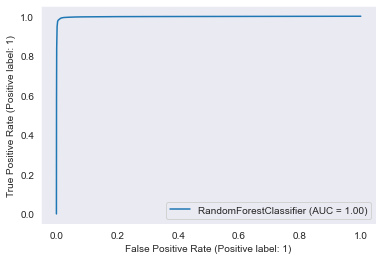

In [46]:
rf.fit(x_train,y_train)
score(rf, x_train,x_test,y_train,y_test,train = True)
score(rf, x_train,x_test,y_train,y_test,train = False)

#### - AdaBoost Classifier.


 ----- Train Result ----- 

Accuracy Score: 0.7866587193708068

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.78      0.80      0.79    137763
           1       0.79      0.77      0.78    137383

    accuracy                           0.79    275146
   macro avg       0.79      0.79      0.79    275146
weighted avg       0.79      0.79      0.79    275146


 ----- Confusion matrix ----- 
 [[110088  27675]
 [ 31025 106358]]

 ----- Test Result ----- 

Accuracy Score: 0.7856644424091761

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     45668
           1       0.79      0.78      0.78     46048

    accuracy                           0.79     91716
   macro avg       0.79      0.79      0.79     91716
weighted avg       0.79      0.79      0.79     91716


 ----- Confusion matrix ----- 
 [[36334  9334]
 [10324 35724]]

 ----- Roc

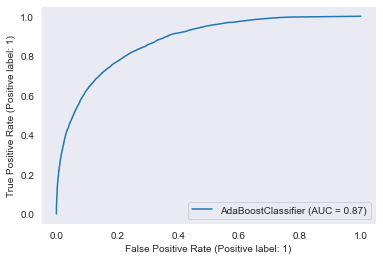

In [47]:
ada.fit(x_train,y_train)
score(ada, x_train,x_test,y_train,y_test,train = True)
score(ada, x_train,x_test,y_train,y_test,train = False)

#### - KNeighbors Classifier.


 ----- Train Result ----- 

Accuracy Score: 0.9199515893380241

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.87      0.99      0.93    137763
           1       0.99      0.85      0.91    137383

    accuracy                           0.92    275146
   macro avg       0.93      0.92      0.92    275146
weighted avg       0.93      0.92      0.92    275146


 ----- Confusion matrix ----- 
 [[136434   1329]
 [ 20696 116687]]

 ----- Test Result ----- 

Accuracy Score: 0.8837825461206332

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.83      0.97      0.89     45668
           1       0.96      0.80      0.87     46048

    accuracy                           0.88     91716
   macro avg       0.90      0.88      0.88     91716
weighted avg       0.90      0.88      0.88     91716


 ----- Confusion matrix ----- 
 [[44322  1346]
 [ 9313 36735]]

 ----- Roc

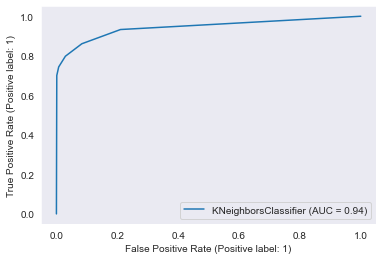

In [48]:
knn.fit(x_train,y_train)
score(knn, x_train,x_test,y_train,y_test,train = True)
score(knn, x_train,x_test,y_train,y_test,train = False)

#### - GradientBoosting Classifier.


 ----- Train Result ----- 

Accuracy Score: 0.8034752458694656

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.80      0.81      0.80    137763
           1       0.81      0.80      0.80    137383

    accuracy                           0.80    275146
   macro avg       0.80      0.80      0.80    275146
weighted avg       0.80      0.80      0.80    275146


 ----- Confusion matrix ----- 
 [[111571  26192]
 [ 27881 109502]]

 ----- Test Result ----- 

Accuracy Score: 0.8014414060796371

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.80      0.81      0.80     45668
           1       0.81      0.80      0.80     46048

    accuracy                           0.80     91716
   macro avg       0.80      0.80      0.80     91716
weighted avg       0.80      0.80      0.80     91716


 ----- Confusion matrix ----- 
 [[36806  8862]
 [ 9349 36699]]

 ----- Roc

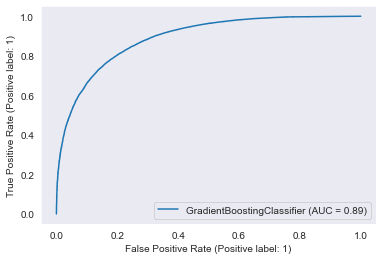

In [49]:
gb.fit(x_train,y_train)
score(gb, x_train,x_test,y_train,y_test,train = True)
score(gb, x_train,x_test,y_train,y_test,train = False)

#### - Logistic Regression.


 ----- Train Result ----- 

Accuracy Score: 0.7537271121513669

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.75      0.75      0.75    137763
           1       0.75      0.75      0.75    137383

    accuracy                           0.75    275146
   macro avg       0.75      0.75      0.75    275146
weighted avg       0.75      0.75      0.75    275146


 ----- Confusion matrix ----- 
 [[103950  33813]
 [ 33948 103435]]

 ----- Test Result ----- 

Accuracy Score: 0.7538161280474508

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.75      0.75      0.75     45668
           1       0.76      0.75      0.75     46048

    accuracy                           0.75     91716
   macro avg       0.75      0.75      0.75     91716
weighted avg       0.75      0.75      0.75     91716


 ----- Confusion matrix ----- 
 [[34419 11249]
 [11330 34718]]

 ----- Roc

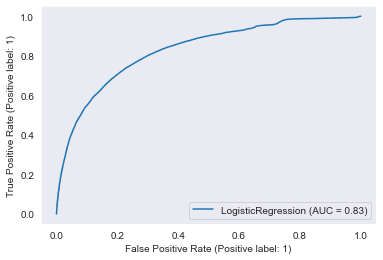

In [50]:
lr.fit(x_train,y_train)
score(lr, x_train,x_test,y_train,y_test,train = True)
score(lr, x_train,x_test,y_train,y_test,train = False)

RandomForest Classifier, is giving the best score among all other models.
# Cross-Validation

In [51]:
k_f = KFold(n_splits = 5,shuffle = True)
k_f

KFold(n_splits=5, random_state=None, shuffle=True)

In [52]:
for train,test in k_f.split(mic):
    print('Train:',train,'\ntest:',test)

Train: [     0      1      3 ... 209589 209591 209592] 
test: [     2     14     23 ... 209580 209586 209590]
Train: [     0      1      2 ... 209590 209591 209592] 
test: [     5      9     15 ... 209567 209574 209584]
Train: [     0      1      2 ... 209588 209589 209590] 
test: [     6     16     22 ... 209587 209591 209592]
Train: [     1      2      4 ... 209590 209591 209592] 
test: [     0      3      7 ... 209583 209588 209589]
Train: [     0      2      3 ... 209590 209591 209592] 
test: [     1      4     10 ... 209569 209582 209585]


In [53]:
cross_val_score(rf,x,y,cv = 5).mean()

0.9792210705348283

Cross Validation Score and model Accuracy score is very close, so we can say that our model is working well and doesn't having the overfitting/underfitting problem present.

#### - Saving the Model.

In [54]:
filename = 'micro.pickle'
pickle.dump(rf, open(filename, 'wb'))